# Assignment 2: Molecular Dynamics
Molecular Dynamics (MD) is a powerful computational tool where the dynamics of particles is studied by solving Newton’s second law $F = ma$ for each particle.

In this assignment, you will create your own MD code (Part 1), where simulations in the Microcanonical (*NVE*) and Canonical (*NVT*) ensemble can be performed, and compute properties of methane, CH<sub>4</sub> (Part 2).

## Instructions for your report
**Note: The instructions are the same as *Assignment 1: Monte Carlo*, and is repeated below for completeness.**

You should send to the course instructors the following item:
- This Jupyter notebook with short and precise answers to the questions.  
- If required, add plots or other figures. Save these figures and output values in such a way that rerunning your entire code is not required for grading the assignment.
- Your codes within this Jupyter notebook, or in an external python file of which the functions are then used within this Jupyter notebook.  
- Make sure that your assignment file and all your code blocks and textual parts in this file clearly report your name.
- As this is a Jupyter notebook, you might spend a lot of time on the code. However note that the explanations you provide in text will play a major role in your grade. so don't forget those.

For answering the questions you can use both the lecture notes and the appropriate chapters in the proposed textbooks. Keep an eye on Brightspace for announcements concerning the assignment.

You can use any programming language of your choice, however, the use of Python 3.x is recommended. The use of [PyCharm](https://www.jetbrains.com/pycharm/) or [VSCode](https://code.visualstudio.com/) as editor which work on Windows, Mac and Linux is also recommended. Some useful functions will also be provided in Python 3.x. Before you start, make sure that basic Python packages such as numpy, matplotlib, scipy and math are installed. Additionally, the plotly python package is also needed if you want to use the `view_trajectory` function.

## Visualizing molecular simulations
In the world of molecular simulations VMD is the preferred tool. You can visualize the trajectory files by opening VMD and going to `File > New Molecule` and choosing the trajectory file and file type LAMMPS Trajectory and clicking Load. To see how the MD simulation advanced in time, in the VMD Main window you can move between frames using the arrow like buttons.

Alternatively, there is a `view_trajectory` function in the `assignment2.py` file, which creates an animation in the notebook for quick debugging. An example for using the function is given below.

In [2]:
from assignment2 import * 
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
import math

data_file = 'data/example/example.xyz'
positions = read_xyz(data_file)
edge_length = 30
box_size = np.array([[0, edge_length],[0, edge_length],[0, edge_length]])
view_trajectory(positions, box_size)

data_file = 'data/example/example.lammpstrj'
positions, velocities, forces, box_sizes = read_lammps_trj(data_file)
view_trajectory(positions, box_sizes[0])

## Coding tips
### Guidelines
Before you start the assignment, note that there are some relevant tips that will reduce the number of mistakes you make while coding. All the listed points went wrong by multiple students the last few years. Therefore keeping them in mind is relevant:

- Units, units, units.
- Use clear names for your variables and functions. When specified, use the same function name as it makes evaluation easier.
- Make sure to write clear comments.
- See if python packages already provide the features you need. It's not neccesary to reinvent the wheel.
- Only use LOCAL variables and avoid GLOBAL variables.
- If you understand types, annotate your python functions. You will get warnings if your inputs are the wrong type or size, making it easier to find mistakes.
- Use numpy as is when you can and avoid for or while loops which reduce your code speed significantly.
- Investigate scaling of your code to make it faster.

If you do not understand what the tip entails of why we advise it you can ask your search engine of choice.

### Tackling performance issues
The goal of the assignment is not to make the fastest code possible, otherwise we would have selected a different code language for the assignment. However, part 2 of this assignment will require you to model CH<sub>4</sub> more rigorously. If you code inefficiently, you will get problems here. From experience we know that students can get simulation times of 3 to 5 hours per state point, where solutions exist in python which give you a result within 5 minutes.

Therefore, it is smart to spend some time on optimizing your code. Investigating the optimization of your code in a jupyter notebook. For example, in the first assignment, you investigate the computational expense of computing the distance of every particle i to every particle j **WITHOUT** accounting for periodic boundary conditions.

This process always has the same steps:
1. Start with a super simple implementation for which you know you will get the right results.
2. Think how you can vectorize your result. This means that you try to do the same operation on all parts of an array at once instead of performing calculations per element in the array.
3. Think about what you really need to compute. Maybe you can leave out parts.
4. Check if your optimized results match the simple approach.
5. Test the speed of the function with the `%timeit` macro in jupyter. On a laptop only test your preformance with wall-power plugged in. On batteries laptops can make really unreliable power choices making comparisons not working well.

## Force field parameters

United-Atom TraPPE methane (CH<sub>4</sub>) Force Field<sup>1</sup>. The force field is described by the Lennard-Jones (LJ) potential given by equation below, with σ and ε parameters provided in Table 1.

### Lennard-Jones potential

$$
U(r) = 4 \epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right] \tag{1}
$$

Table 1: Force Field parameters for TraPPE United Atom methane

| Parameter               | Value   |
|-------------------------|---------|
| $\sigma$ [Å]            | 3.730   |
| $\epsilon/k_B$ [K]      | 148.0   |

<sup>1</sup> [TraPPE Force Field Information](http://chem-siepmann.oit.umn.edu/siepmann/trappe/index.html)

## Units
In Molecular Dynamics, we use certain units to well represent and compare the world in the nanoscale. To make your life easier, we highly recommend the use Angstroms *Å*, for distance units, *kJ/mol* for energy units, *fs* for time units and *g/mol* for mass units. You can make use of the following conversions and constants:

| Quantity                        | Value / Expression                                                                 |
|--------------------------------|-------------------------------------------------------------------------------------|
| Boltzmann constant             | $k_B = 1.380649 \times 10^{-26}$ kJ/K                                               |
| Avogadro's number              | $N_A = 6.02214076 \times 10^{23}$ 1/mol                                            |
| Gas constant                   | $R = k_B \cdot N_A = 0.008314462175$ kJ/(mol·K)                                     |
| Kinetic Energy                 | $KE = \sum \frac{1}{2}mv^2 \rightarrow$ (g/mol)(Å/fs)$^2 \times 10^4$ = kJ/mol      |
| $\epsilon$ K → kJ/mol          | $\epsilon \cdot R$                                                                 |
| Forces                         | kJ/(mol·Å)                                                                          |
| Acceleration                   | Force / mass = (kJ)/(mol·Å) / (g/mol) $\times 10^{-4}$ = Å/fs²                     |


In [3]:
# simulation parameters
nDim = 3
Nfreq = 100   # sample frequency
R = 0.0019872041     # Boltzmann constant / NA [Kcal/molK]
NA = 6.022140857e23 # Avogadros number
kB = 0.0019872041
# 1 cal = 4.184 J

# some unit conversions
# 1 cal = 4.184 J
# 1 J = 1 Kg m^2 / s^2
# 1 Kg = 1e3 g
# 1m = 1e10 Angstrom
# 1s = 1e15 fs
# 1 Kg m^2 / s^2 = 1e3*(1e10/1e15)^2 = 1e-7  g Angstrom^2 / fs^2
# Kcal/mol = 4.184 * 1e-4 g/mol*(Angstrom/fs)^2
# g/mol*(Angstrom/fs)^2 = 1/(4.184 * 1e-4) Kcal/mol


# Part 1: Development of MD solver
## 1 Setting up a system
### 1.1 Initial configuration
#### 1.1.1 Particle Initialization and RDF Analysis

In the first stage of development, you will set up a system comprising a simulation box of size $L$ in $n$ dimensions and fill it with particles at a specified density. You could, for example, use a Monte Carlo approach of randomly inserting particles without creating overlap (or eliminating overlap using MC translation moves) until the desired density is achieved.

Here, you will define a simulation box of size $L$ and fill it with $N$ methane particles on a lattice with a specified spacing to achieve the desired density. A 2D version is presented below called `initGrid()`. Modify this version to support particle assignment on a lattice in **1D**, **2D**, and **3D**. Plot the rdf using `rdf` function in `assignment2.py`.

---

#### 1.1.2 Simulation Task

Create a simulation box with dimensions:

- $L_x = L_y = L_z = 30$ Å

Fill this box with methane particles at the following densities:

- $\rho = 358.4$ kg/m³
- $0.5\rho$
- $2\rho$

For each system:

1. **Calculate the RDF** (radial distribution function)
2. **Plot all RDFs in a single figure**, and discuss the differences.
3. **Present VMD/Jupyter snapshots** for each system.

---

#### Hint
You need to calculate the number of particles by converting the target density to units of g/(mol·Å³), then round to the nearest integer to determine how many methane particles fit in the box. 

Make sure unit conversions are accurate and that the system remains physically reasonable (i.e., no overlapping particles).

In [22]:
def initGrid(L, nPart, dim):
    '''
    function to determine particle positions and box size for a specified number of particles and density

    Start at the empty array coords in which we will place the coordinates of the particles.
    Create an additional variable called L which shall give the box dimension (float).
    Make sure to shift the coordinates to have (0,0,0) as the center of the box.

    Fill the box with particles without overlap and correct density

    You can check the positioning of particles using a scatter plot
    import matplotlib.pyplot as plt
    plt.figure()
    plt.scatter(x, y)
    plt.show()

    :param L: box dimension
    :param rho: density of particles [number per unit length]

    :return: coordinates centered around origin
    :return: box size
    '''
    if dim == 1:
        # 1D case
        n_axis = nPart
        spac   = L / n_axis

        coords = np.zeros((nPart, 1))
        for i in range(nPart):
            coords[i, 0] = i * spac

        # centering part by substracting half extent to the coordinates
        half_extent = (n_axis - 1) / 2 * spac
        coords_centered = coords - half_extent
        return coords_centered, L

    elif dim == 2:
        #2D case
        n_axis = int(math.ceil(nPart**(1/2))) 
        spac   = L / n_axis
        coords = np.zeros((nPart, 2))
        count  = 0

        for i in range(n_axis):
            for j in range(n_axis):
                if count >= nPart:
                    break
                coords[count, 0] = i * spac
                coords[count, 1] = j * spac
                count += 1
            if count >= nPart:
                break

        
        half_extent = (n_axis - 1) / 2 * spac
        coords_centered = coords - half_extent
        return coords_centered, L

    elif dim == 3:
        # In 3D
        n_axis = int(math.ceil(nPart**(1/3)))
        spac   = L / n_axis
        coords = np.zeros((nPart, 3))
        count  = 0

        for i in range(n_axis):
            for j in range(n_axis):
                for k in range(n_axis):
                    if count >= nPart:
                        break
                    coords[count, 0] = i * spac
                    coords[count, 1] = j * spac
                    coords[count, 2] = k * spac
                    count += 1
                if count >= nPart:
                    break
            if count >= nPart:
                break

        
        half_extent = (n_axis - 1) / 2 * spac #center by subtracting half extent to te coordinates
        coords_centered = coords - half_extent
        return coords_centered, L

    else:
        raise ValueError("dim must be 1, 2, or 3.")

M = 0.01604 # in kg/mol
NA = sc.Avogadro # in mol^-1
rho1 = 358.4 # in kg/m^3
rho2 = rho1/2
rho3 = rho1*2
L = 30  # in angstrom
L_meter = L *1e-10  # in meters
nPart = int((rho1* L_meter**3) /(M/NA))
nPart2 = int((rho2* L_meter**3) /(M/NA))
nPart3 = int((rho3* L_meter**3) /(M/NA))

position1, L1 = initGrid(30, nPart, dim=3)
position2, L2 = initGrid(30, nPart2, dim=3)
position3, L3 = initGrid(30, nPart3, dim=3)
L1_box = np.array([L1, L1, L1]) #creates the box size for the first set of particles
L2_box = np.array([L2, L2, L2]) #creates the box size for the second set of particles
L3_box = np.array([L3, L3, L3]) #creates the box size for the third set of particles

# Calculate the radial distribution function for each set of particles
rdf_1, g_1 = rdf(position1, L1_box)
rdf_2, g_2 = rdf(position2, L2_box)
rdf_3, g_3 = rdf(position3, L3_box)


box_3D = np.array([[-L1/2, L1/2], [-L1/2, L1/2], [-L1/2, L1/2]]) #create a box for 3D visualization


trajectory = np.array([position1])


view_trajectory(trajectory, box_3D)




trajectory2 = np.array([position2])


view_trajectory(trajectory2, box_3D)

trajectory3 = np.array([position3])


view_trajectory(trajectory3, box_3D)

<h3><span style="color:green">Answer 1.1</span></h3>

<div style="color:green">

Massimiliano Toffoli -- 2025-06-02   

In the function above the boxes at various densitities are filled. To do a sanity check three 3D boxes were plotted at 0.5ρ, 1ρ and 2ρ. The results show that the particles are well spaced and the box is being filled as it should.

<p>Finally, in the lower part the rdf of all 3 density cases are plotted. A sanity check is done to check the validity of it. For 0.5ρ, for a box length of 30 Angstroms, the lattice spacing is 30/6 = 5 (where 6 is naxis from the function), which is exactly where the first peak of the curve is. Moreover, the following peaks should be at sqrt(2) * 5 which is around 7, exactly where the second peak is. When analysing the 1ρ case, the lattice displacement is 30/8 = around 3.75 Angstroms, which is where the first peak of the rdf function is found. Finally the same can be seen with the case of 2ρ, where the peak is at 30/9 = around 3.33 Angstroms  </p>

</div>

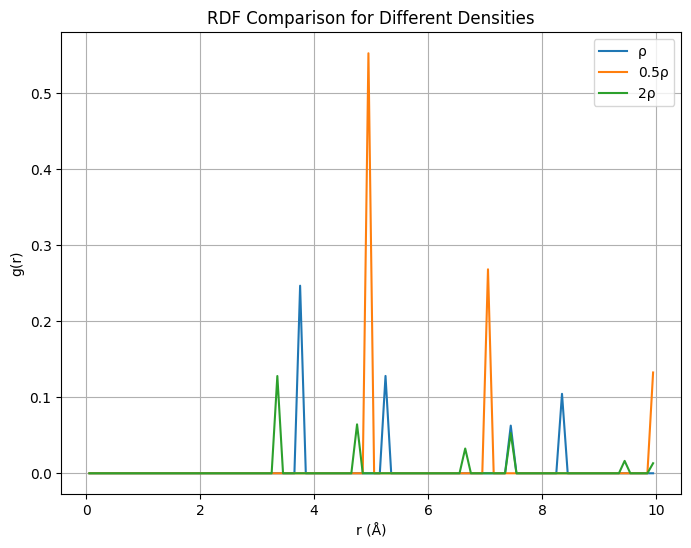

In [23]:
#positions_2d, box_size = initGrid(30, 100)

# Now we can use the function to create a grid of particles
# import plotly.graph_objects as go
# fig = go.Figure(go.Scatter(x=positions_2d[:,0], y=positions_2d[:,1], mode='markers'))
# fig.update_layout(
#     title="2D Particle Grid",
#     xaxis_title="X-axis",
#     yaxis_title="Y-axis",
#     showlegend=False,
#     # width=800,
#     # height=800,
# )
# fig.show()
plt.figure(figsize=(8, 6))
plt.plot(rdf_1, g_1, label='ρ')
plt.plot(rdf_2, g_2, label='0.5ρ')
plt.plot(rdf_3, g_3, label='2ρ')
plt.xlabel('r (Å)')
plt.ylabel('g(r)')
plt.title('RDF Comparison for Different Densities')
plt.legend()
plt.grid(True)
plt.show()




### 1.2 Setting the temperature
Once the particles are assigned their initial positions, the system needs to be given a temperature. Create a function called `initVel()` in which you assign a random velocity to each particle and scale the velocities based on the temperature using the following relation:

$$
\frac{1}{2}\langle m \mathbf{v}^2 \rangle = \frac{1}{2} n_{\text{dim}} k_B T
$$

Where:

- $m$ is the mass of a methane particle  
- $\mathbf{v}$ is the initial velocity vector  
- $n_{\text{dim}}$ is the dimensionality of the system  
- $k_B$ is the Boltzmann constant  
- $T$ is the temperature  

> **Note:** If you use the mass in g/mol, you can simply use the gas constant $R$ instead of $k_B$.

### Additional Considerations

Can you think of any other considerations necessary when assigning velocities?

---

<h3><span style="color:green">Answer 1.2</span></h3>

<div style="color:green">

Massimiliano Toffoli -- 2025 -06 -04  

The function initVel assigns random velocities, based on the dimension of the system (1D,2D,3D). To conserve total momentum and to avoid drift, the center of mass velocity is substracted to those velocities. <p>Moreover, since the random velocities are sampled from a gaussian distribution, the actual and the target kinetic energy are calculated. Their ratio is then used as a factor to scale the velocities to match the kinetic energy. As a debugging step, the temperature is being printed, to check whether the temperature the rescaling actually brought the temperature close to the input value.</p>



</div>

In [6]:
# def initVel(...):
def initVel(nPart, T, dim, m):

    kB = sc.Boltzmann  # Boltzmann constant in J/K
    
    sigma = np.sqrt(kB * T / m) #calculate the standard deviation for the velocity distribution

    if dim == 1:
        # 1D case
        velocities = np.random.normal(0, sigma, nPart)
        

    elif dim == 2:
        # 2D case
        velocities = np.random.normal(0, sigma, (nPart, 2))
        

    elif dim == 3:
        # 3D case
        velocities = np.random.normal(0, sigma, (nPart, 3))
        

    else:
        raise ValueError("dim must be 1, 2, or 3.")
    
    v_cm = np.mean(velocities, axis=0)
    velocities = velocities - v_cm  # Remove center of mass velocity to avoid drift
    
    KE_actual = 0.5 * m * np.mean(np.sum(velocities**2, axis=1)) # Calculate actual kinetic energy
    KE_target = 0.5 * dim * kB * T # calculate target kinetic energy
    scaling = np.sqrt(KE_target / KE_actual) #calculate scaling factor to match target kinetic energy
    velocities = velocities * scaling  # Scale velocities to match target kinetic energy

    #for debugging purposes calculate final temperature
    #T_final = (m * np.mean(np.sum(velocities**2, axis=1))) / (dim * kB)
    #print("Final temperature:", T_final," K")

    return velocities

nPart = 362    
M = 0.01604  # Molar mass of the particle in kg/mol
NA = sc.Avogadro  # Avogadro's number in mol^-1
T = 150  # Temperature in Kelvin    
dim = 3  # Dimension of the system
velocities = initVel(nPart, T, dim, M/NA)  # Initialize velocities for the particles




## 2 Implement a force potential

In the second development stage, the forces acting on each particle from $\mathbf{F} = m \mathbf{a}$ can be obtained using the (LJ) potential given by equation 1. This equation is generally given in energy format, describing the potential energy of particles. To solve Newton's second law the forces are required, which are obtained from $F = -\frac{dU}{dr}$. Derive this expression and document your steps.

The implementation can best be implemented by splitting the problem into two parts:
1. Computing the distance $r_{ij}$ and vector $v_{ij}$ between particles $i$ and $j$
2. Computing the LJ forces

### 2.1 Distance and vector between particles

Calculate the distance between particles in a similar manner as was done in the MC assignment. You can just copy-paste those lines into this assignment.  

For the vector you can start at your distance function, but you need to consider the orientation of the vector to get good final results.  

*Hint: Make a drawing.*

<h3><span style="color:green">Answer 2.1</span></h3>

<div style="color:green">

Massimiliano Toffoli -- 2025-06-05 

The code below, was adapted from assignment 1, it calculates the distance between the particles in a vectorized form (so the vector direction goes from j to i). Then the periodic boundary condtion is applied and finally the module of the distance is calculated. <p>This function returns then the vector and the scalar of the distance which is then needed to compute the Lennard Jones force</p>

</div>

In [7]:
def distances (pos, Lbox):
    
    dr =  pos[:, np.newaxis, :] - pos[np.newaxis, :, :] #calculating the distance between the particles in a vectorized form by using the broadcasting feature of numpy
    dr = dr - Lbox * np.round(dr / Lbox) #apply periodic boundary conditions
    r = np.sqrt(np.sum(dr**2,axis=2)) #module of the distance

    return dr, r


### 2.2 Implement force equation

Implement an equation to compute the forces in a function called `LJ_forces()` and add the option to include a cut-off. Use the skeleton provided below.

<h3><span style="color:green">Answer 2.2</span></h3>

<div style="color:green">

Massimiliano Toffoli -- 2025-06-05  

This code has been adapted from the observable function of assignment 1. The structure has been adapted to calculate the scalar of the LJ Force and then the force vector is calculated by multiplying the scalar force with the displacement vectors using broadcasting.
<p>Finally a list of index pairs is calculated so that it can be used in the loop to apply Newton's law. After applying it the force vector is returned. </p>

</div>

In [8]:
def LJ_forces (pos,Lbox, Rcut, epsilon, sigma):
    
    
    N = pos.shape[0]  # calculate number of particles
    dim = pos.shape[1]
    F=np.zeros(pos.shape)
    dr, r = distances(pos, Lbox)
    
    mask = (r < Rcut) & (r > 1e-14) & np.triu(np.ones((N, N), dtype=bool), k=1) #condition where the Lennard-Jones potential is calculated, added condition to avoid division by zero and to avoid double counting
    
    r_accepted = r[mask]
    
    F_scal = (-24 * epsilon * (2 * sigma**12 / r_accepted**13 - sigma**6 / r_accepted**7)) # derivative of the Lennard-Jones potential
    
    F_vec = F_scal[:, np.newaxis] * dr[mask] # python broadcasting function to get vector with shape: (N, N, dim)
    
    #loop to apply Newtons law
    pairs = np.array(np.where(mask)).T  #  get list of (i, j) index pairs for which the force is computed by using transpose

    for k, (i, j) in enumerate(pairs): #loop for getting F vector
        # Apply equal and opposite forces to particle i and j (using Newton's third law)
        F[i] = F[i]+ F_vec[k]
        F[j] = F[j]- F_vec[k]
    
    return F


## 3 Implementing integrator
The velocity-Verlet algorithm is the most commonly used algorithm in MD. Write a velocity Verlet algorithm as specified in the lecture slides in a function called `velocityVerlet()`.

Note that particles can leave the simulation box during time integration and need to be placed back inside the primary simulation box.

<h3><span style="color:green">Answer 3</span></h3>

<div style="color:green">

Massimiliano Toffoli -- 2025-06-05  

Here the Velocity-Verlet Algorithm was used. SO first the new position at t+dt is calculated, then the periodic BC is applied (taken from MC code) and then the updated velocity after half timestep is calculated. The next step is then to calculate the new LJ force at t+dt and finally the last step is to update the velocity at t+dt by using the provided formulas in the slides.

</div>

In [9]:
def velocityVerlet(pos, vel, F, dt, mass, Lbox, Rcut, epsilon, sigma):
    
    pos = pos + vel *dt + 1/(2*mass) *F *dt**2 #calculate new position
    
    pos = pos - Lbox * np.round(pos / Lbox) #apply periodic boundary condition
    
    vel_dthalf = vel + 0.5* F/mass *dt #updated velocity after half timestep
    
    F_new = LJ_forces(pos, Lbox, Rcut, epsilon, sigma) #calculate the new LJ force
    
    vel = vel_dthalf + 0.5 * (F_new) /mass * dt # update the velocity
    
    return vel, pos, F_new


## Obtaining Useful Results

Write functions to compute the **kinetic energy**, **potential energy**, **temperature**, and **pressure**, from here on named **state variables**.  

Give the following names to the respective functions:

- `kineticEnergy()`
- `potentialEnergy()`
- `temperature()`
- `pressure()`

It is very likely you can copy most of these from your MC assignment, but you should check the **units**.

Place the **velocity Verlet integrator** and the **printing of state variables** inside a loop for time integration, as shown below to create the `MDSolve` function:

---

### Algorithm 1: MDSolve

```plaintext
for t from 0 to tend do
    Velocity Verlet integrator
    if mod(t / sample_frequency) equals 0 then
        provide outputs
    end if
end for
```

---

Set the print frequency to every 100 steps for later analysis of the data.
Furthermore, you can use the function write_frame(coords, vels, forces, outputfilename, step) to output the positions, velocities, and net forces on each particle.
This allows you to separate the simulation and analysis parts.

The format of the output file provided by this function is as follows:

```plaintext
ITEM: TIMESTEP
0
ITEM: NUMBER OF ATOMS
100
ITEM: BOX BOUNDS pp pp pp
xlo xhi
ylo yhi
zlo zhi
ITEM: ATOMS id type xu yu zu vx vy vz fx fy fz 
1 1 x y z vx vy vz fx fy fz 
...
ITEM: TIMESTEP
100
...
```

A function to read these files is provided and can be called by writing: 

`xyz, vel, forces = read_lammps_trj(filename)`

> **Note:** The `log.dat` file allows you to plot the evolution of state parameters.

<h3><span style="color:green">Answer 4</span></h3>

<div style="color:green">

Student Name (NetID) -- YYYY-MM-DD HH:MM  

Write your answer here.

</div>

In [ ]:

def kineticEnergy(vel, mass):

    return 0.5 * mass * np.sum(vel**2)  # calculate total kinetic energy 
def potentialEnergy(pos, Lbox, Rcut, epsilon, sigma):

    N = pos.shape[0]  # calculate number of particles
    F=np.zeros(pos.shape)
    dr, r = distances(pos, Lbox)
    
    mask = (r < Rcut) & (r > 1e-14) & np.triu(np.ones((N, N), dtype=bool), k=1) #condition where the Lennard-Jones potential is calculated, added condition to avoid division by zero and to avoid double counting
    
    r_accepted = r[mask]
    energy = 4 * epsilon * ((sigma / r_accepted) ** 12 - (sigma / r_accepted) ** 6)  # calculate the Lennard-Jones potential

    return energy.sum()  # return the total potential energy

def temperature(KE, N, dim): #calculate temperature from kinetic energy (formula from lecture 7 slide 26)

    return (2 * KE) / (N * dim * sc.Boltzmann)  # calculate temperature from kinetic energy


def pressure(pos, vel, mass, Lbox, Rcut, epsilon, sigma):

    N = pos.shape[0]  # number of particles
    V = Lbox ** 3
    kb = sc.Boltzmann
    dim = pos.shape[1]  # number of dimensions
    dr, r = distances(pos, Lbox)  # calculate distances between particles
    mask = (r < Rcut) & (r > 1e-14) & np.triu(np.ones((N, N), dtype=bool), k=1) #condition where the Lennard-Jones potential is calculated, added condition to avoid division by zero and to avoid double counting
    
    r_accepted = r[mask]
    
    F_scal = (-24 * epsilon * (2 * sigma**12 / r_accepted**13 - sigma**6 / r_accepted**7)) # derivative of the Lennard-Jones potential
    
    F_vec = F_scal[:, np.newaxis] * dr[mask] # python broadcasting function to get vector with shape: (N, N, dim)
    r_vec = dr[mask]  # extract corresponding distance vectors for the accepted pairs
    KE = kineticEnergy(vel, mass)  # calculate kinetic energy
    T = temperature(KE, N, dim) #calculate temperature from kinetic energy
    P = (N * kb * temperature(kineticEnergy(vel, mass), N, pos.shape[1]) / V)+  1/(6*V) * np.sum(np.einsum('ij,ij->i',F_vec, r_vec))  # calculate pressure using the virial theorem
   

    return P

def write_frame(pos, vel, F, filename, step): #Needs fixing, not sure if it works correctly
    N = pos.shape[0]
    with open(filename, 'a') as f:
        f.write(f"ITEM: TIMESTEP\n{step}\n")
        f.write(f"ITEM: NUMBER OF ATOMS\n{N}\n")
        f.write("ITEM: BOX BOUNDS pp pp pp\n")
        for _ in range(3):
            f.write(f"{-0.5*Lbox} {0.5*Lbox}\n")
        f.write("ITEM: ATOMS id type xu yu zu vx vy vz fx fy fz\n")
        for i in range(N):
            line = (f"{i+1} 1 " +
                    " ".join(map(str, pos[i])) + " " +
                    " ".join(map(str, vel[i])) + " " +
                    " ".join(map(str, F[i])) + "\n")
            f.write(line)

def MDSolve (pos, vel, mass, Lbox, Rcut, epsilon, sigma, dt, steps, sample_freq, output_file): #function to solve the molecular dynamics 

    with open(output_file, 'w') as f: #open output file in write mode
        for t in range(steps):
            
            vel, pos, F = velocityVerlet(pos, vel, F, dt, mass, Lbox, Rcut, epsilon, sigma) #update positions and velocities using the velocity Verlet algorithm after first time step

            if t % sample_freq == 0:
                write_frame(pos, vel, F, f, t)    #update the output file with the current positions, velocities, and forces

    return

dT = (Tend - Tstart)/steps
Temp = Tstart
time = 0
dt2 = dt * dt

# with open('log', 'a') as file:
#     file.write('Step KE Upot totE\n')
# print('Step T KE Upot totE')

# def MDSolve(...):
#     for step in range(steps+1):

#         # integrate
#         # cords, vels, forces, xi = velocityVerletThermostat(coords, L, vels, forces, xi, mass, dt, dt2, kB * Temp, sigma, epsilon, cutoff, Tdamp)
#         # coords, vels, forces = velocityVerlet(coords, L, vels, forces, mass, dt, dt2, sigma, epsilon, cutoff)

#         # wrap coordinates
#         coords = wrap(coords, L)

#         time += dt
#         Temp += dT

#         # write outputs
#         if step%Nfreq == 0:
#             KE = # kinetic energy
#             Upot = # potential energy
#             Tempi = # instantaneous temperature

#             print('%i %.4f %.4f %.4f %.4f' %(step, Tempi, KE, Upot, KE+Upot))
#             with open('log.dat', 'a') as file:
#                 file.write('%i %.4f %.4f %.4f %.4f\n' %(step, Tempi, KE, Upot, KE+Upot))

#             # write a file with atom coordinates
#             write_frame(coords, L, vels, forces, 'trajectory', step)

#     return ...

NameError: name 'Tend' is not defined

## 5 Verification

Run your first simulation using the force field parameters specified in the beginning of the assignment and additionally the system parameters mentioned below

In [ ]:
# simulation parameters
nDim = 3
Nfreq = 100   # sample frequency

# CH4 methane
sigma = 3.73 # [angstrom]
epsilon = 148 * kB # [K]
mass = 16.04 # [g/mol]

# density
rho = 358.4 # kg/m3
L = 30 # Angstrom
L_meter = L * 1e-10  # convert Angstrom to meters
nPart = int((rho1* L_meter**3) /(M/NA))
#nPart = rho * L ** 3 * mass # * correct the units!!! Will it be an integer?

# Simulation parameters
steps = 3000 # length of simulation run [fs]
dt = 1     # timestep [fs]

# temperature
T = 150   # [K]

Hint: If you could not make your own system, you may continue loading a data file using:

In [ ]:
xyz, vel, L = read_lammps_data('lammps.data')

You can compare the results to those provided in the folder `VERIFY1`. Provide plots of the state variables vs time comparing your results to those obtained from the LAMMPS MD simulation package. Use the data file provided with initial positions and velocities. 

Note that the energy results in the VERIFY1 folder are given in kcal/mol. 

4.184 J = 1 cal

<h3><span style="color:green">Answer 5</span></h3>

<div style="color:green">

Student Name (NetID) -- YYYY-MM-DD HH:MM  

Write your answer here.

</div>

## 6 Thermostat
### 6.1 Implement velocity Verlet Thermostat
For many practical applications, the temperature needs to be controlled. Therefore you will now implement a thermostat in a function called `velocityVerletThermostat()`. The Nosé-Hoover thermostat alters the velocity Verlet integrator adding the extra variable $\zeta$. 

Implement the equations below as a new integrator type. Note that $\text{KE} = \sum_i^{N} \frac{1}{2} m v(t)^2$. You can also treat the kinetic energy as $\frac{1}{N} \text{KE}$ in which case you need to treat $\frac{3N+1}{2} k_B T$ as $\frac{3}{2} k_B T$. The only difference of both formulations is the value of $Q$.

$$
\begin{aligned}
r(t + \Delta t) &= r(t) + v(t) \Delta t + \frac{\Delta t^2}{2} \left(\frac{F(t)}{m} - \zeta(t) v(t)\right) \\
\zeta\left(t+\frac{\Delta t}{2}\right) &= \zeta(t) + \frac{\Delta t}{2Q} \left(\text{KE} - \frac{3N+1}{2} k_B T\right) \\
v\left(t + \frac{\Delta t}{2}\right) &= v(t) + \frac{\Delta t}{2} \left(\frac{F(t)}{m} - \zeta\left(t+ \frac{\Delta t}{2}\right) v(t)\right) \\
&\text{\textbf{update forces}} \\
\zeta(t+\Delta t) &= \zeta\left(t+\frac{\Delta t}{2}\right) + \frac{\Delta t}{2Q} \left(\text{KE} - \frac{3N+1}{2} k_B T \right) \\
v(t + \Delta t) &= \frac{v\left(t+ \frac{\Delta t}{2}\right) + \frac{\Delta t}{2}\frac{F(t + \Delta t)}{m}}{1 + \frac{\Delta t}{2}\zeta(t + \Delta t)}
\end{aligned}
$$

<h3><span style="color:green">Answer 6.1</span></h3>

<div style="color:green">

Student Name (NetID) -- YYYY-MM-DD HH:MM  

Write your answer here.

</div>

In [ ]:
# def velocityVerletThermostat(coords, L, vels, forces, xi, mass, dt, dt2, kBTemp, sigma, epsilon, cutoff, Tdamp):
#     '''
#     function to integrate the equations of motion using the velocity Verlet algorithm
#     with a Langevin thermostat

#     :param coords: coordinates of particles
#     :param L: box size
#     :param vels: velocities of particles
#     :param forces: forces acting on particles
#     :param xi: random force
#     :param mass: mass of particles
#     :param dt: time step
#     :param dt2: time step squared
#     :param kBTemp: Boltzmann constant times temperature
#     :param sigma: Lennard-Jones parameter
#     :param epsilon: Lennard-Jones parameter
#     :param cutoff: cutoff distance for forces
#     :param Tdamp: damping time constant

#     :return: updated coordinates, velocities, forces and random force
#     '''

#     # update positions and velocities using the velocity Verlet algorithm

#     return coords, vels, forces, xi

### 6.2 Tuning the damping factor $Q$
$Q$ is a damping parameter which needs to be tuned by the user. Vary the parameter $Q$ and report what you observe when running the simulation. You can compare the results to those provided in the folder `VERIFY2`. Use both, the data file provided with initial positions and velocities, and your `initGrid` and `initVel` functions to create the initial conditions. 

Provide plots of the state variables vs time comparing your results to those obtained from the LAMMPS MD simulation package.

<h3><span style="color:green">Answer 6.2</span></h3>

<div style="color:green">

Student Name (NetID) -- YYYY-MM-DD HH:MM  

Write your answer here.

</div>

# Part 2: Application of the MD-NVT code

To check the correct working of your MD code and to see that many of the same properties can be computed with MD and MC, reproduce the results you obtained from your MC code. 

Use the TraPPE force field for CH<sub>4</sub>: LJ parameters: $\sigma = 3.73 \text{Å}$ and 
$\epsilon/k_B = 148 \text{K}$

> **Note:** In all questions, use a truncated potential **without tail correction**. Other simulation parameters are given below and can be changed as needed.

This is also a good time to add all your above functions to the `assignment2.py` file. Why, you may ask: it is so that we can call the functions in the jupyter notebook as a bash command (using the python subprocess function). Ensure to *Restart* the python notebook kernel after adding the functions, so that python re-caches the imported python file. If you are using VS Code, there is a button at the top to do it.

In [ ]:
# Simulation parameters
nDim = 3
Nfreq = 100   # sample frequency
R = 0.0019872041     # Boltzmann constant / NA [Kcal/molK]
NA = 6.022140857e23 # Avogadros number
# 1 cal = 4.184 J

# CH4 methane
sigma = 3.73 # [angstrom]
epsilon = 148*kB # [K]
mass = 16.04 # [g/mol]

# MD configuration
rho = 358.4 # kg/m3 density
L = 30 # Å box size
nPart = rho * L ** 3 * mass # * correct the units!!! Will it be an integer?

# Simulation parameters
steps = 100000 # length of simulation run [fs] (may take very long)
dt = 1     # timestep [fs]

# temperature
T = 150   # [K]

## 1 Determine convergence
Assume a temperature $T$ = 150 K and a density $\rho$ = 358.4 kg m<sup>-3</sup>. Assume a cubic box with side lengths $L$ = 30 $\AA$ and cutoff distance of 10 $\AA$. 

1. Run the MD simulation for 10,000 steps with a timestep of 1 fs and plot the energy of the system as a function of the steps. 

2. How can you establish based on that plot that the system reached equilibrium? 

3. How many steps does it take for the system to reach equilibrium?

4. Report the average energy and the error (standard deviation) of the energy of the system.

<h3><span style="color:green">Answer 1</span></h3>

<div style="color:green">

Student Name (NetID) -- YYYY-MM-DD HH:MM  

Write your answer here.

</div>

## 2 Compute the P-T diagram of CH$_4$ using NVT MD

Compute and report the P-T diagrams of CH<sub>4</sub> at the following densities and temperatures:

- $\rho$ = 358.4 kg m<sup>3</sup> at $T$ = 100, 200, 300 and 400 K
- $\rho$ = 1.6 kg m<sup>3</sup> at $T$ = 100, 200, 300 and 400 K

To create the systems use the function `initGrid`. For the case of the lower density (1.6 kg m<sup>3</sup>) use also $N$ = 362 and set the cutoff distance at 50 Å.

The obtained results should be in agreement with the experimentally measured quantities. To check whether your simulation is close to reality, please visit the website of [NIST Chemistry WebBook](https://webbook.nist.gov/chemistry/fluid/) and choose the right settings to check your result. On this website you will find data for methane derived by Equations of state, which are based on experimental results. 

Plot your results (P-T curves along with the NIST data). Remember that the quality of the force field (here TraPPE) is very important. You may observe deviations from the NIST data even if your MC code is correct.

*Hint 1: Make sure that your system is equilibrated and then start sampling averages.*

*Hint 2: The time for each calculation depends on the computational power of your PC, the efficiency of the MD implementation and the system size. On a normal laptop one simulation can take up to approximately 2 hours. Use `%timeit` to test various strategies for improving computational time. If your computer is very slow, please contact the TAs and we may provide the necessary data files.*

<h3><span style="color:green">Answer 2</span></h3>

<div style="color:green">

Student Name (NetID) -- YYYY-MM-DD HH:MM  

Write your answer here.

</div>

## 3 Radial Pair Distribution Functions

Use the `rdf` function provided in `assignment2.py` to compute the RDF of methane at the thermodynamic conditions:

- $\rho$ = 358.4 kg m<sup>3</sup> at $T$ = 100, 200, 300 and 400 K
- $\rho$ = 1.6 kg m<sup>3</sup> at $T$ = 100, 200, 300 and 400 K

Provide two plots, each one containing the RDFs at a given density and the various temperatures.

<h3><span style="color:green">Answer 3</span></h3>

<div style="color:green">

Student Name (NetID) -- YYYY-MM-DD HH:MM  

Write your answer here.

</div>

## 4 VMD
Using VMD is a key part of doing MD simulations, especially for your future employer/research group. Therefore, as a part of your learning, use the VMD tool to provide snapshots of your system at thermodynamic conditions:

- $\rho$ = 358.4 kg m<sup>3</sup> at $T$ = 100, 200, 300 and 400 K
- $\rho$ = 1.6 kg m<sup>3</sup> at $T$ = 100, 200, 300 and 400 K

Provide 8 total snapshots, for 2 densities from 100 to 400 Kelvin.

> **Note:** Use `![image.png](attachment:image.png)` to insert pictures in the answer block

<h3><span style="color:green">Answer 4</span></h3>

<div style="color:green">

Student Name (NetID) -- YYYY-MM-DD HH:MM  

Write your answer here.

</div>